## step01

In [1]:
from main import *

In [2]:
import numpy as np

# Variable 인스턴스 = x 생성
data = np.array(1.0)
x = Variable(data)
print(x.data)

1.0


In [3]:
# 보충
x = np.array(1)
print(x.ndim)
y = np.array([1, 2, 3])
print(y.ndim)
z = np.array([[1, 2, 3],
              [4, 5, 6]])
print(z.ndim)

0
1
2


## step02

In [4]:
x = Variable(np.array(10))
f = Square()        # 변수 입력 x
y = f(x)            # 여기서 변수 입력  / 부모 클래스의 __call__ 메서드
print(type(y))
print(y.data)

<class 'main.Variable'>
100


## step04

In [5]:
# 수치 미분을 사용한 복잡한 함수의 미분
def f(x):
    A = Square()
    B = Exp()
    C = Square()
    return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
print(dy)

3.2974426293330694


## step06

In [6]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# x -> A(x) = a -> B(a) = b -> C(b) = y
# x.grad = dy/dx <- a.grad = dy/da <- b.grad = dy/db <- y.grad = 1 = dy/dy
y.grad = np.array(1.0)
b.grad = C.backward(y.grad)     # 앞선 기울기를 입력으로 받는다.
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)

## step07
> 역전파 자동화에 대한 내용. 순전파를 실행하면 순전파의 실행 순서를 기억하고 그 순서의 반대로 역전파가 이루어지도록 구조를 만든다. <br> Define-by_Run

![그림 7-3.png](<attachment:그림 7-3.png>)
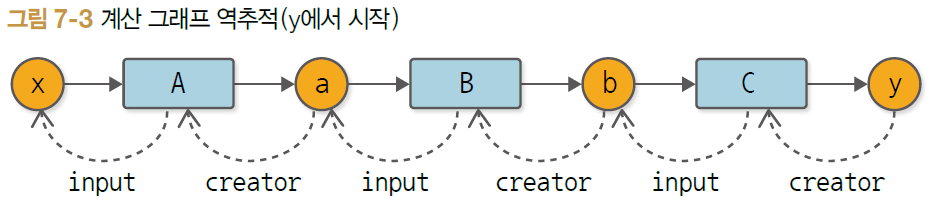

In [7]:
# 순전파
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 계산 그래프의 노드들을 거꾸로 거슬러 올라간다.
assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x

y.grad = np.array(1.0)
                                # b : Variable -> C() : Function -> y
C = y.creator                   # 1. 함수를 가져온다.
b = C.input                     # 2. 함수의 입력을 가져온다.
b.grad = C.backward(y.grad)     # 3. 함수의 backward 메서드를 호출한다.

B = b.creator
a = B.input
a.grad = B.backward(b.grad) 

A = a.creator
x = A.input
x.grad = A.backward(a.grad)

print(x.grad)

3.297442541400256


In [8]:
# Variable에 backward 메서드 추가 후 역전파
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


## step08
> 재귀함수를 반복문(while)로 교채

In [9]:
# def backward(self):
#     f = self.creator                    # 1. 함수를 가져온다
#     if f is not None:                   
#         x = f.input                     # 2. 함수의 입력을 가져온다.
#         x.grad = f.backward(self.grad)  # 3. 함수의 backward 메서드를 호출한다.
#         x.backward()                    # creator == None인 input(parameter)까지 호출한다(재귀).  / 재귀는 메모리 효율이 좋지 않음

## step09

In [10]:
x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.backward()
print(x.grad)

3.297442541400256


In [11]:
# 본문에는 나와있지만, np.array()함수로 대체 가능하다 생각하며 대체함
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

## step10
> 테스트

In [17]:
import unittest

class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)
    
    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)

    def test_gradient_check(self):
        x = Variable(np.random.rand(1))         # 임의의 값 생성
        y = square(x)
        y.backward()                            # 역전파 미분값
        num_grad = numerical_diff(square, x)    # 수치미분
        flg = np.allclose(x.grad, num_grad)
        self.assertTrue(flg)

# unittest.main()